In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import PercentFormatter
import scipy.stats as spstats


In [2]:
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 7.5)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22


 # Computational Statistics Homework 06
 Kalin Gibbons  
 2020-03-12


 ## Problem 1
 
 ---

 Use the EM algorithm to fit a $(1 - \pi)\ : \ \pi$ mixture of two Poisson
 distributions, Poisson($\lambda_1$) and Poisson($\lambda_2$), to the
 following data:

In [3]:
value = np.arange(0, 10)
frequency = np.array([162, 267, 271, 185, 111, 61, 27, 8, 3, 1])
data_df = pd.DataFrame(
    {'value': value, 'frequency': frequency}
).set_index('value')
data_df.T


value,0,1,2,3,4,5,6,7,8,9
frequency,162,267,271,185,111,61,27,8,3,1


<br>
<br>
<br>

### (a) Derive the EM algorithm for the maximum likelihood estimators of $\theta$

Derive the MLE estimators for $\pi, \lambda_1, \lambda_2$. Present your derivation in a markdown cell in the Jupyter notebook.

#### Likelihood function
$$L(\theta | Y) = f(y; \theta)$$

 $$ = f(x | z, \theta) f(z | \theta)$$

 $$ = \prod_{j=1}^n \left[ \phi(x_j; \lambda_1)^{(1 - z_j)}  \phi(x_j; \lambda_2)^{z_j} \right] \left[(1 - \pi)^{(1 - z_j)} \pi^{z_j}\right]$$

 Where $\phi(x_j; \lambda_i)$ is the $i$th Poisson PDF evaluated at the $j$th sample value, and $z_j$ is a binary indicator function with probabilities

 $$P(Z = 1) = \pi$$

 and

 $$P(Z = 0) = (1 - \pi).$$

 Taking the logarithm of the likelihood function,

 $$
 \ell(\theta | Y) = \sum_{j=1}^n \left[ (1 - z_j) \log \phi_1 + z_j \log \phi_2 \right]
 + \sum_{j=1}^n \left[ (1 - z_j) \log (1 - \pi) + z_j \log \pi \right].
 $$

 #### Expectation step
 Now, the expectation of the joint log likelihood for the complete data,
 conditional on the observed data is:

 $$Q(\theta | \theta^{(t)}) = E_Z \left\{ \ell(\theta | Y) \ |\ x, \theta^{(t)} \right\}$$

 $$ = \sum_{j=1}^n (1 - z_j^{(t)}) \log \phi_1 + z_j^{(t)} \log \phi_2 + (1 - z_j^{(t)}) \log (1 - \pi) + z_j^{(t)} \log \pi$$

 where

 $$z_j^{(t)} = E(Z_j | x, \theta^{(t)})$$

 $$ = \sum_{j=1}^n z_j f(z_j | x_j, \theta^{(t)})$$



 $$= 0 f(Z_j=0 | x_j, \theta^{(t)}) + 1 f(Z_j=1 | x_j, \theta^{(t)})$$

 $$ = \frac{f(x_j, z_j = 1 | \theta^{(t)})}{f(x_j | \theta^{(t)})}$$

 $$\therefore z_j^{(t)} = \frac{\pi \phi(x_j; \lambda_2^{(t)})}{ (1 - \pi) \phi(x_j | \lambda_1^{(t)}) + \pi \phi (x_j | \lambda_2^{(t)})}$$


#### Maximization step

Since our indicator function $Z_j = 1$ for a $\pi$ proportion of samples, and zero otherwise, the MLE of $\pi$ is

$$
\hat{\pi} = \sum_{j=1}^n z_j / n
$$

For the Poisson parameters, the MLEs are found by setting the partial derivatives of $Q(\theta | \theta^{(t)})$ equal to zero and solving for each

$$
\hat{\lambda_1} = \frac{\sum_{j=1}^n x_j \left( 1 - z_j \right)} {n - \sum_{j=1}^n z_j}
$$

and

$$
\hat{\lambda_2} = \frac{\sum_{j=1}^n x_j  z_j} {\sum_{j=1}^n z_j}
$$

Our log-likelihood function is linear in $z_j$, so we can replace them by their current conditional expectation $z_j^{(t)}$ to yield the maximization step

$$
\pi^{(t+1)} = \sum_{j=1}^n z_j^{(t)} / n
$$


$$
\lambda_1^{(t+1)} = \frac{\sum_{j=1}^n x_j \left( 1 - z_j^{(t)} \right)} {n - \sum_{j=1}^n z_j^{(t)}}
$$


$$
\lambda_2^{(t+1)} = \frac{\sum_{j=1}^n x_j  z_j^{(t)}} {\sum_{j=1}^n z_j^{(t)}}
$$

We may now iterate the expectation and maximization steps until convergence is acquired.

<br>
<br>
<br>

### (b) Implement the EM algorithm for this data set
Present the output of your code in a format similar to Table 4.1 on page 102 of the book _Computational Statistics_.

In [4]:
def calc_r(vec_list, tol=1e-6):
    vec_list = np.asarray(vec_list)
    vec_new = vec_list[-1]
    vec_prev = vec_list[-2]
    numerator = np.linalg.norm(vec_new - vec_prev)
    denominator = np.linalg.norm(vec_prev)
    if denominator == 0:
        denominator += tol
    relative_delta = numerator / denominator
    return relative_delta


def poisson_pmf(x, lambda_):
    y = lambda_ ** x / scipy.special.factorial(x) * np.exp(-lambda_)
    return y


def expected_z(x, fit_params):
    pi = fit_params[0]
    lam_1 = fit_params[1]
    lam_2 = fit_params[2]
    numer = pi * poisson_pmf(x, lam_2)
    denom = (1 - pi) * poisson_pmf(x, lam_1) + pi * poisson_pmf(x, lam_2)
    exp_z = numer / denom
    return exp_z


def pi_next(exp_z_list):
    exp_z_list = np.array(exp_z_list)
    pi_new = exp_z_list.mean()
    return pi_new


def lambda_1_next(exp_z_list, x_list):
    exp_z_list = np.array(exp_z_list)
    x_list = np.array(x_list)
    n_data = x_list.size
    numer = (x_list * (1 - exp_z_list)).sum()
    denom = n_data - exp_z_list.sum()
    lam_1_new = numer / denom
    return lam_1_new


def lambda_2_next(exp_z_list, x_list):
    exp_z_list = np.array(exp_z_list)
    x_list = np.array(x_list)
    lam_2_new = (exp_z_list * x_list).sum() / exp_z_list.sum()
    return lam_2_new


def theta_next(exp_z_list, x_list):
    pi_new = pi_next(exp_z_list)
    lam_1_new = lambda_1_next(exp_z_list, x_list)
    lam_2_new = lambda_2_next(exp_z_list, x_list)
    theta_new = np.hstack((pi_new, lam_1_new, lam_2_new))
    return theta_new


# Table items
def calc_d(vec_list, idx):
    vec_list = np.array(vec_list)[-2:]
    # Values found by running EM to 1e-16 precision.
    # Compare against ordinary 1e-6 precision (or some other relaxed precision)
    if idx == 0:  # pi
        phat = 0.35988539669507946
    if idx == 1:  # h1
        phat = 2.6634043562785052
    if idx == 2:  # h2
        phat = 1.2560951007204648
    p = vec_list[:, idx]
    return np.abs(p[-1] - phat) / np.abs(p[-2] - phat)


def exp_max_update(x_list, prev_theta):
    x_list = np.array(x_list)
    z_new = expected_z(x_list, prev_theta)
    theta_new = theta_next(z_new, x_list)
    return theta_new


def expectation_maximization(x_list, init_theta):
    x_list = np.array(x_list)
    init_theta = np.array(init_theta)
    new_theta = exp_max_update(x_list, init_theta)
    theta_list = np.vstack((init_theta, new_theta))
    r = calc_r(theta_list)
    r_list = np.array((np.nan, r))
    d_pi_list = np.array((np.nan, calc_d(theta_list, idx=0)))
    d_h1_list = np.array((np.nan, calc_d(theta_list, idx=1)))
    d_h2_list = np.array((np.nan, calc_d(theta_list, idx=2)))
    n_iter = [0, 1]
    while not r_list[-1] < 1e-6:
        n_iter.append(n_iter[-1] + 1)
        new_theta = exp_max_update(x_list, theta_list[-1])
        theta_list = np.vstack((theta_list, new_theta))
        r_list = np.append(r_list, calc_r(theta_list))
        d_pi_list = np.append(d_pi_list, calc_d(theta_list, idx=0))
        d_h1_list = np.append(d_h1_list, calc_d(theta_list, idx=1))
        d_h2_list = np.append(d_h2_list, calc_d(theta_list, idx=2))
    n_keep = 8
    df_dict = {
        '$t$': n_iter[-n_keep:],
        '$\pi$': theta_list[-n_keep:, 0],
        '$\lambda_1$': theta_list[-n_keep:, 1],
        '$\lambda_2$': theta_list[-n_keep:, 2],
        '$R$': r_list[-n_keep:],
        '$D_\pi$': d_pi_list[-n_keep:].round(3),
        '$D_{\lambda_1}$': d_h1_list[-n_keep:].round(3),
        '$D_{\lambda_2}$': d_h2_list[-n_keep:].round(3)
    }
    return pd.DataFrame(df_dict)


Let's first take a look at the sample distribution, so that our initial guesses may be reasonable.

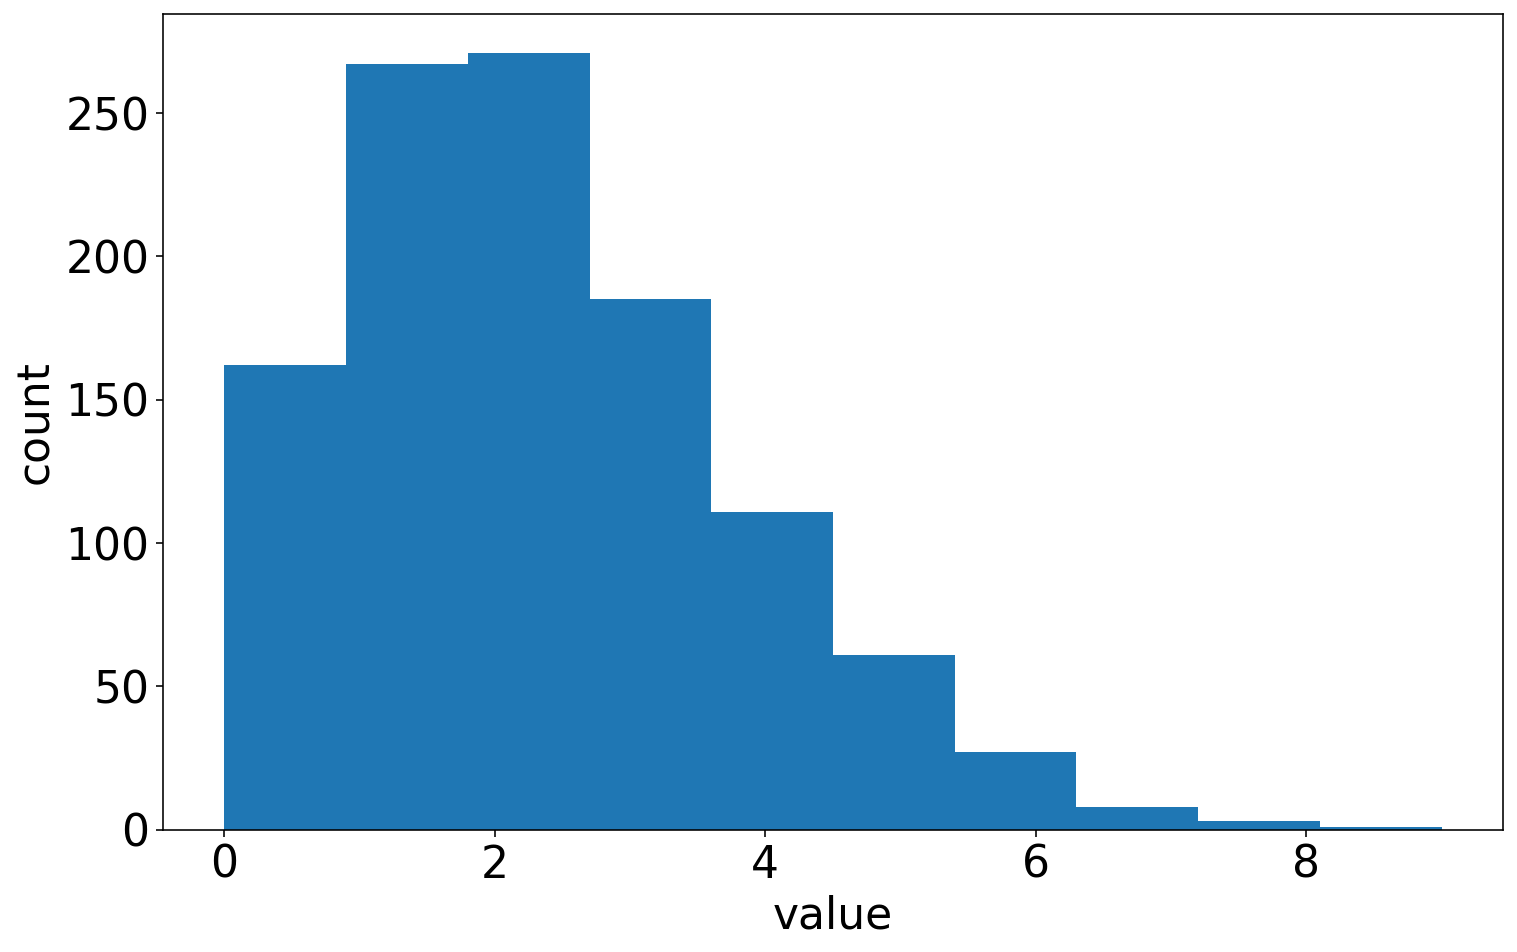

In [5]:
data = np.nan
for val, freq in data_df.iterrows():
    data = np.append(data, val * np.ones(freq))
data = data[1:]

plt.hist(data)
plt.ylabel('count')
plt.xlabel('value')
plt.show()


 Looks like the bulk of the data resides near the value of two. Since the
 Poisson distribution is very right skewed when $\lambda$ is low, we'll assign
 a small proportion of the data to a distribution with $\lambda = 1$, and a
 larger proportion to a distribution with $\lambda = 3$.
 

In [6]:
pi, lam_1, lam_2 = (0.1, 3, 1)
init_theta = (pi, lam_1, lam_2)
df = expectation_maximization(data, init_theta)
df.set_index('$t$')


,$\pi$,$\lambda_1$,$\lambda_2$,$R$,$D_\pi$,$D_{\lambda_1}$,$D_{\lambda_2}$
$t$,,,,,,,
1474,0.359586,2.663039,1.255575,1.030594e-06,0.996,0.996,0.996
1475,0.359588,2.663041,1.255578,1.026123e-06,0.996,0.996,0.996
1476,0.359589,2.663043,1.255580,1.021671e-06,0.996,0.996,0.996
1477,0.359590,2.663044,1.255582,1.017239e-06,0.996,0.996,0.996
1478,0.359592,2.663046,1.255584,1.012827e-06,0.996,0.996,0.996
1479,0.359593,2.663047,1.255586,1.008433e-06,0.996,0.996,0.996
1480,0.359594,2.663049,1.255589,1.004058e-06,0.996,0.996,0.996
1481,0.359595,2.663050,1.255591,9.997027e-07,0.996,0.996,0.996


 These results seem reasonable. Our $\pi$ remained below 0.5, our $\lambda_1$
 remained near 3, and our $\lambda_2$ remained near unity.

<br>
<br>
<br>

### (c)Show the relative frequency and fitted probability for the observed data

Use a single plot, with an appropriate legend.

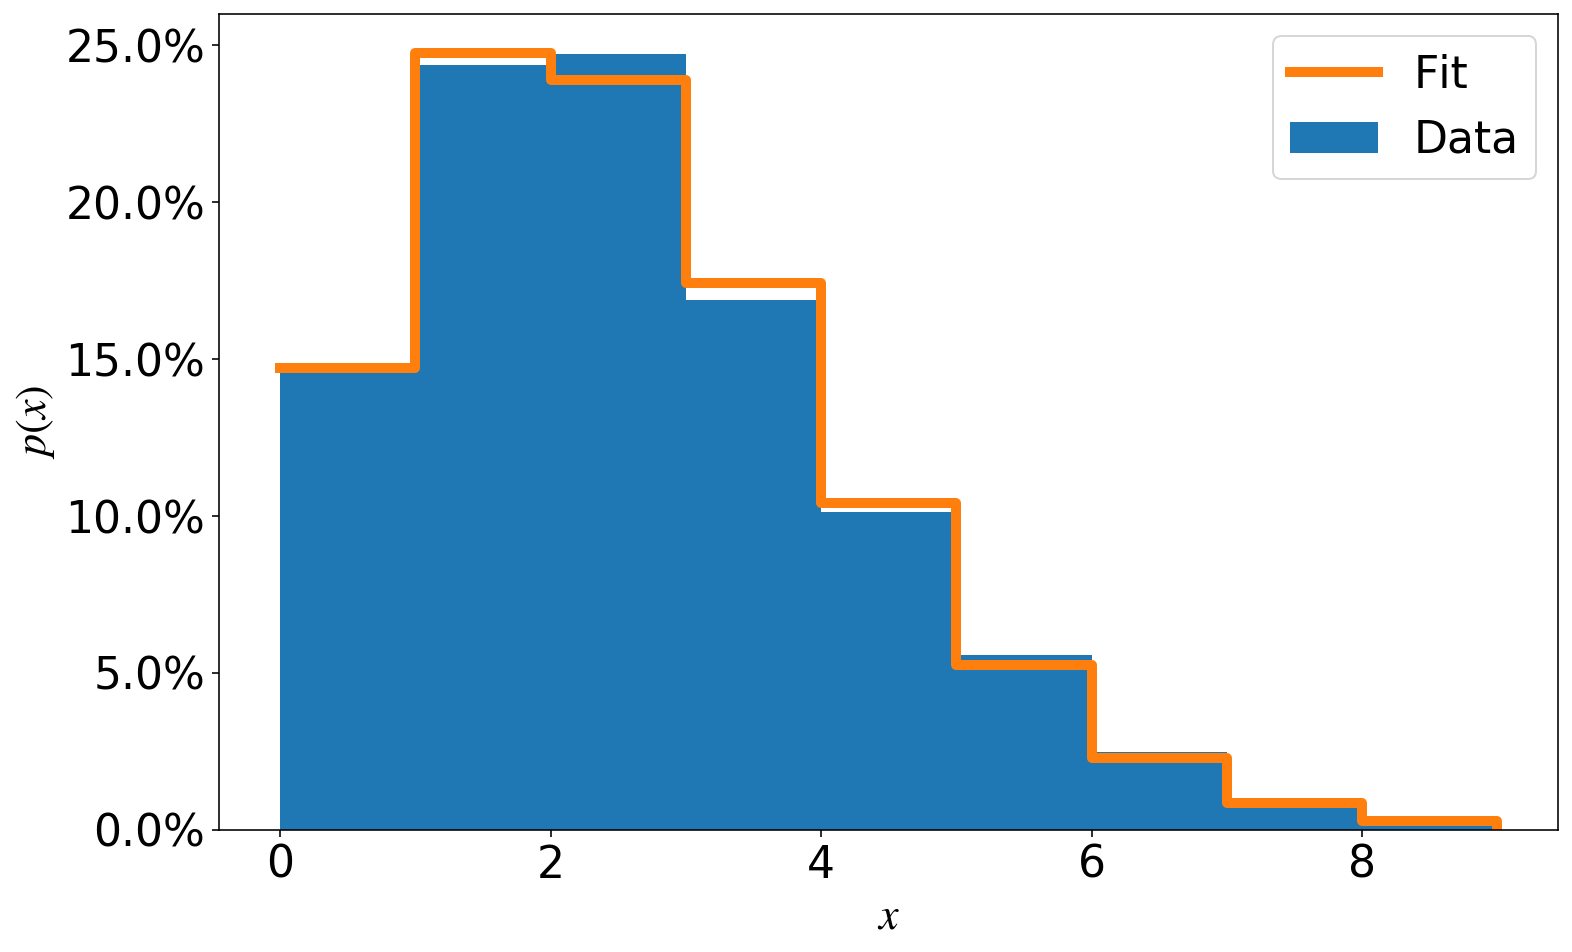

In [7]:
plt.hist(data, bins=range(data_df.size), density=True, label='Data')
plt.ylabel('$p(x)$')
plt.xlabel('$x$')
(plt.gca()).yaxis.set_major_formatter(PercentFormatter(xmax=1))


def mixed_pmf(x, theta):
    theta = np.array(theta)
    pi = theta[0]
    h1 = theta[1]
    h2 = theta[2]
    prob = (1 - pi) * poisson_pmf(x, h1) + pi * poisson_pmf(x, h2)
    return prob


theta_hat = df.iloc[-1, 1:4].to_numpy()
fitted_pmf = mixed_pmf(
    np.arange(data_df.index.min(), data_df.index.max() + 1), theta_hat
)

plt.plot(fitted_pmf, drawstyle='steps-post', linewidth=5, label='Fit')
plt.legend()
plt.show()


 The fit matched the data very nearly, and the plot is shown using discrete
 values. We could probably get a slightly better fit by decreasing the
 tolerance, but this is a very good fit already.

<br>
<br>

### (d) What is the probability that the value 10 will be observed?

 I would expect it to be nearly zero, as there was no training data with that
 particular value.

In [8]:
prob_10 = mixed_pmf(10, theta_hat)
print(f'The probability that the value 10 will be observed is {prob_10:.5f}.')


The probability that the value 10 will be observed is 0.00022.


 <br>
 <br>
 
 ## Problem 2
 
 ---

 Suppose that the probability density function (PDF) of a bivariate random
 vector $\mathbf{X} = (X_1, X_2)^\mathrm{T}$ is a mixture of bivariate normal:

 $$f(x;\mathbf{\theta}) = (1 - \pi) \phi(\mathbf{x}; \mathbf{\mu_1}, \mathbf{\Sigma_1}) + \pi \phi(\mathbf{x}; \mathbf{\mu_2}, \mathbf{\Sigma_2}),$$

 where $\phi(\mathbf{x}; \mathbf{\mu}, \mathbf{\Sigma})$ is the bivariate
 normal pdf with mean $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$,
 and $\mathbf{\theta} = [\pi, \mathbf{\mu_1}, \mathbf{\mu_2}, \mathbf{\sigma_1}, \mathbf{\sigma_2}]$.

 The dataset _data_mvnorm2mix.csv_ is a random sample from these two normal
 mixtures. Implement the EM algorithm to find the maximum likelihood estimate
 (MLE) of the parameter $\mathbf{\theta}$. Present your result as following:

 * (a) Print the MLE of the parameter $\mathbf{\theta}$.

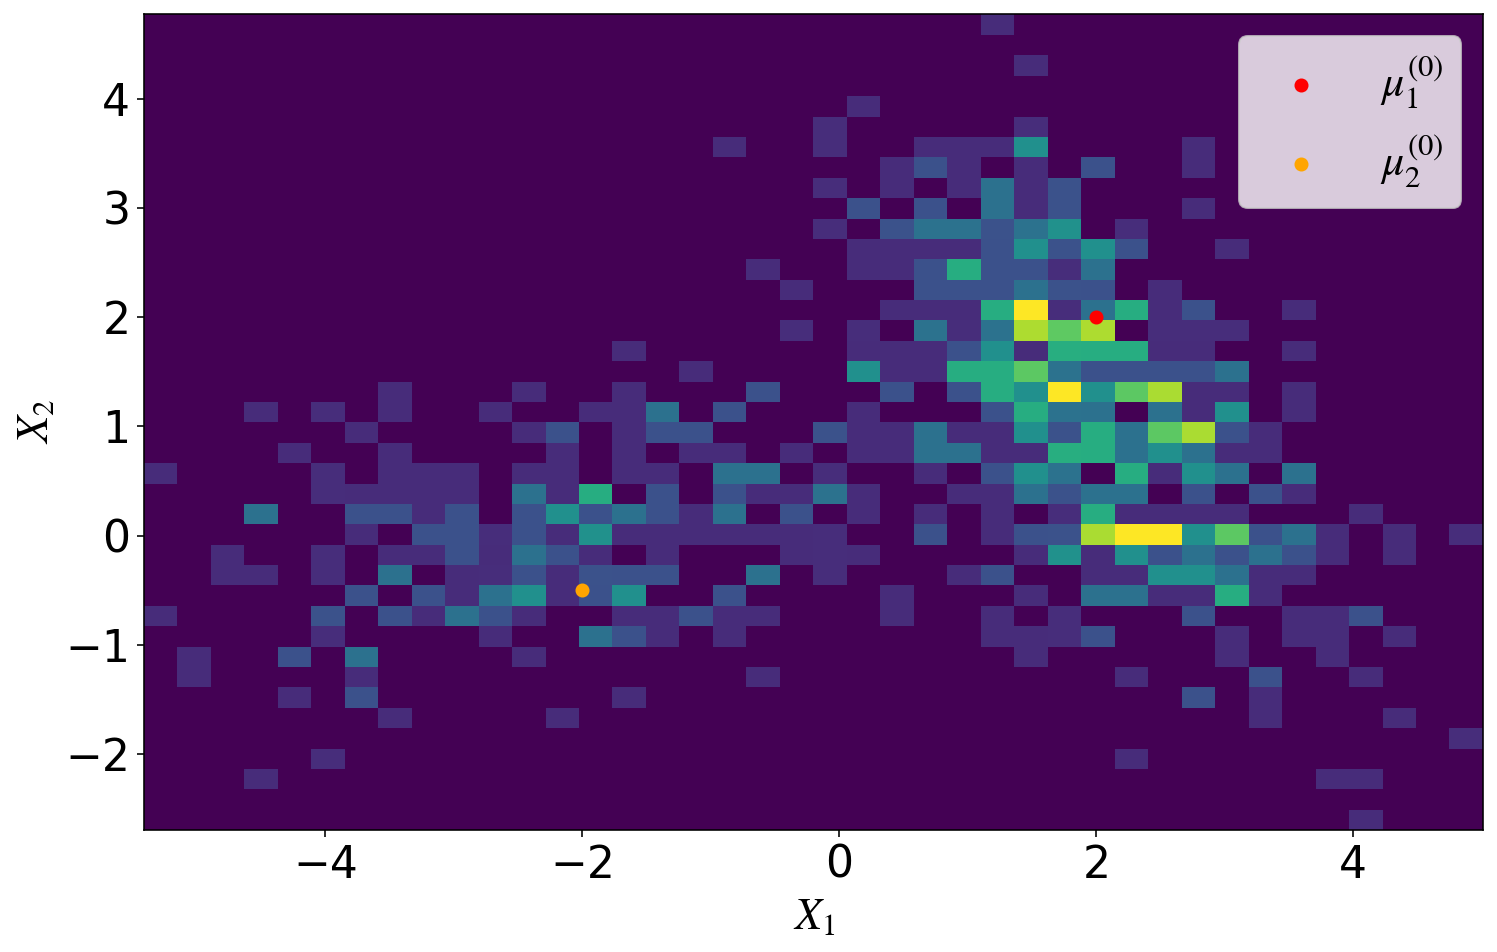

In [9]:
data = pd.read_csv(Path.cwd() / '..' / 'data' / 'data_mvnorm2mix.csv',
                   names=('x1', 'x2'))


def expected_z(x, fit_params):
    x = np.array(x)
    pi = fit_params[0]
    mu_1 = fit_params[1]
    sig_1 = fit_params[2]
    mu_2 = fit_params[3]
    sig_2 = fit_params[4]
    mvn_1 = spstats.multivariate_normal.pdf(x, mean=mu_1, cov=sig_1)
    mvn_2 = spstats.multivariate_normal.pdf(x, mean=mu_2, cov=sig_2)
    numer = pi * mvn_2
    denom = (1 - pi) * mvn_1 + pi * mvn_2
    exp_z = numer / denom
    return exp_z


def pi_next(exp_z_list):
    exp_z_list = np.array(exp_z_list)
    pi_new = exp_z_list.mean()
    return pi_new


def mu_next(proportional, x_list):
    x_list = np.array(x_list)
    numer = proportional @ x_list
    denom = proportional.sum()
    new_mu = numer / denom
    return new_mu


def sig_next(proportional, x_list, new_mu):
    x_list = np.array(x_list)
    n = x_list.shape[0]
    deviation = x_list - new_mu  # mu is 2 x 1
    numer = (proportional * deviation.T) @ deviation
    denom = proportional.sum()
    new_sig = numer / denom
    return new_sig


def theta_next(exp_z_list, x_list):
    new_pi = pi_next(exp_z_list)
    new_mu_1 = mu_next(1 - exp_z_list, data)
    new_sig_1 = sig_next(1 - exp_z_list, data, new_mu_1)
    new_mu_2 = mu_next(exp_z_list, data)
    new_sig_2 = sig_next(exp_z_list, data, new_mu_2)
    theta_new = [(new_pi, new_mu_1, new_sig_1, new_mu_2, new_sig_2)]
    return theta_new


def exp_max_update(x_list, prev_theta):
    x_list = np.array(x_list)
    z_new = expected_z(x_list, prev_theta)
    theta_new = theta_next(z_new, x_list)
    return theta_new


def has_relative_convergence(vec_list, tol=1e-6):
    vec_list = np.asarray(vec_list)
    vec_new = vec_list[-1]
    vec_prev = vec_list[-2]
    delta = vec_new - vec_prev
    numerator = np.linalg.norm(delta @ delta)
    denominator = np.linalg.norm(vec_prev @ vec_prev)
    if denominator == 0:
        denominator += tol
    return numerator / denominator < tol


def expectation_maximization(x_list, init_theta):
    x_list = np.array(x_list)
    init_theta = np.array(init_theta)
    new_theta = exp_max_update(x_list, init_theta)
    theta_list = np.vstack((init_theta, new_theta))
    n_iter = np.array([0, 1])
    while not has_relative_convergence(theta_list):
        n_iter = np.append(n_iter, n_iter[-1] + 1)
        new_theta = exp_max_update(x_list, theta_list[-1])
        theta_list = np.vstack((theta_list, new_theta))

    df_dict = {
        '$t$': n_iter,
        '$\pi$': theta_list[:, 0].astype(float),
        '$\mu_1$':list(map(lambda x: x.astype(float), theta_list[:, 1])),
        '$\Sigma_1$': list(map(lambda x: x.astype(float), theta_list[:, 2])),
        '$\mu_2$': list(map(lambda x: x.astype(float), theta_list[:, 3])),
        '$\Sigma_2$': list(map(lambda x: x.astype(float), theta_list[:, 4]))
    }
    df = pd.DataFrame(df_dict)
    return df

n_bin = 40
plt.figure()
plt.hist2d(data.loc[:, 'x1'], data.loc[:, 'x2'], bins=(n_bin, n_bin),
           density=True)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
init_pi = 0.30
init_mu_1 = np.array([2, 2])
init_sig_1 = np.eye(2)
init_mu_2 = np.array([-2, -0.5])
init_sig_2 = np.eye(2)
plt.scatter(init_mu_1[0], init_mu_1[1], color='red', label=r'$\mu_1^{(0)}$')
plt.scatter(init_mu_2[0], init_mu_2[1], color='orange', label=r'$\mu_2^{(0)}$')
plt.legend()
plt.show()

 The dots marking the initial values were added after the initial plotting of
 the 2D histogram. Rather than attempt to create a positive definite matrix
 that makes sense for each of the $\Sigma_i$, we'll just assume initial values
 of the identity matrix.

In [10]:
init_theta = [init_pi, init_mu_1, init_sig_1, init_mu_2, init_sig_2]
mvnorm_df = expectation_maximization(data, init_theta)
theta_hat = mvnorm_df.iloc[-1, 1:]
disp_df = mvnorm_df.iloc[:, 0:2]
for column in mvnorm_df.columns[2:]:
    disp_df[column] = mvnorm_df[column].apply(lambda x: x.round(4))
disp_df.set_index(disp_df.columns[0])


,$\pi$,$\mu_1$,$\Sigma_1$,$\mu_2$,$\Sigma_2$
$t$,,,,,
0,0.300000,"[2.0, 2.0]","[[1.0, 0.0], [0.0, 1.0]]","[-2.0, -0.5]","[[1.0, 0.0], [0.0, 1.0]]"
1,0.281964,"[1.918, 1.1402]","[[0.9237, -0.6171], [-0.6171, 1.4622]]","[-2.2184, -0.0474]","[[1.5999, 0.2081], [0.2081, 0.5049]]"
2,0.292358,"[1.9473, 1.1453]","[[0.8734, -0.6391], [-0.6391, 1.4817]]","[-2.1423, -0.0177]","[[1.7104, 0.2679], [0.2679, 0.5113]]"
3,0.298180,"[1.9602, 1.1486]","[[0.8571, -0.6488], [-0.6488, 1.4892]]","[-2.0928, -0.0026]","[[1.8082, 0.2984], [0.2984, 0.521]]"
4,0.301620,"[1.9668, 1.1504]","[[0.8504, -0.6538], [-0.6538, 1.4934]]","[-2.0617, 0.0062]","[[1.8763, 0.3176], [0.3176, 0.5275]]"
5,0.303753,"[1.9705, 1.1515]","[[0.847, -0.6568], [-0.6568, 1.496]]","[-2.042, 0.0118]","[[1.9215, 0.33], [0.33, 0.5318]]"
6,0.305115,"[1.9728, 1.1522]","[[0.8451, -0.6586], [-0.6586, 1.4977]]","[-2.0292, 0.0153]","[[1.9512, 0.338], [0.338, 0.5346]]"
7,0.306001,"[1.9742, 1.1526]","[[0.844, -0.6598], [-0.6598, 1.4988]]","[-2.0209, 0.0176]","[[1.9709, 0.3433], [0.3433, 0.5364]]"
8,0.306584,"[1.9751, 1.1529]","[[0.8432, -0.6605], [-0.6605, 1.4995]]","[-2.0154, 0.0192]","[[1.984, 0.3468], [0.3468, 0.5376]]"


In [11]:
theta_hat_df = pd.DataFrame(disp_df.iloc[-1, 1:].T)
theta_hat_df.columns = ['$\hat{\theta}$']
theta_hat_df


,$\hat{\theta}$
$\pi$,0.30751
$\mu_1$,"[1.9766, 1.1533]"
$\Sigma_1$,"[[0.8421, -0.6617], [-0.6617, 1.5006]]"
$\mu_2$,"[-2.0066, 0.0216]"
$\Sigma_2$,"[[2.0049, 0.3523], [0.3523, 0.5396]]"


These values look good. The means did not move too much, and the covariance matrices have symmetric covariances in the off-diagonals. Additionally, $\Sigma_1$ shows more variance in the $X_2$ (vertical) direction, while $\Sigma_2$ shows more variance in the $X_1$ (horizontal) direction, as evidenced by comparing the $\Sigma^{(i)}_{k,k}$ components.

<br>
<br>

### (b) Plot the value of the log-likelihood function versus iteration number.

Comment on the pattern of the plot.

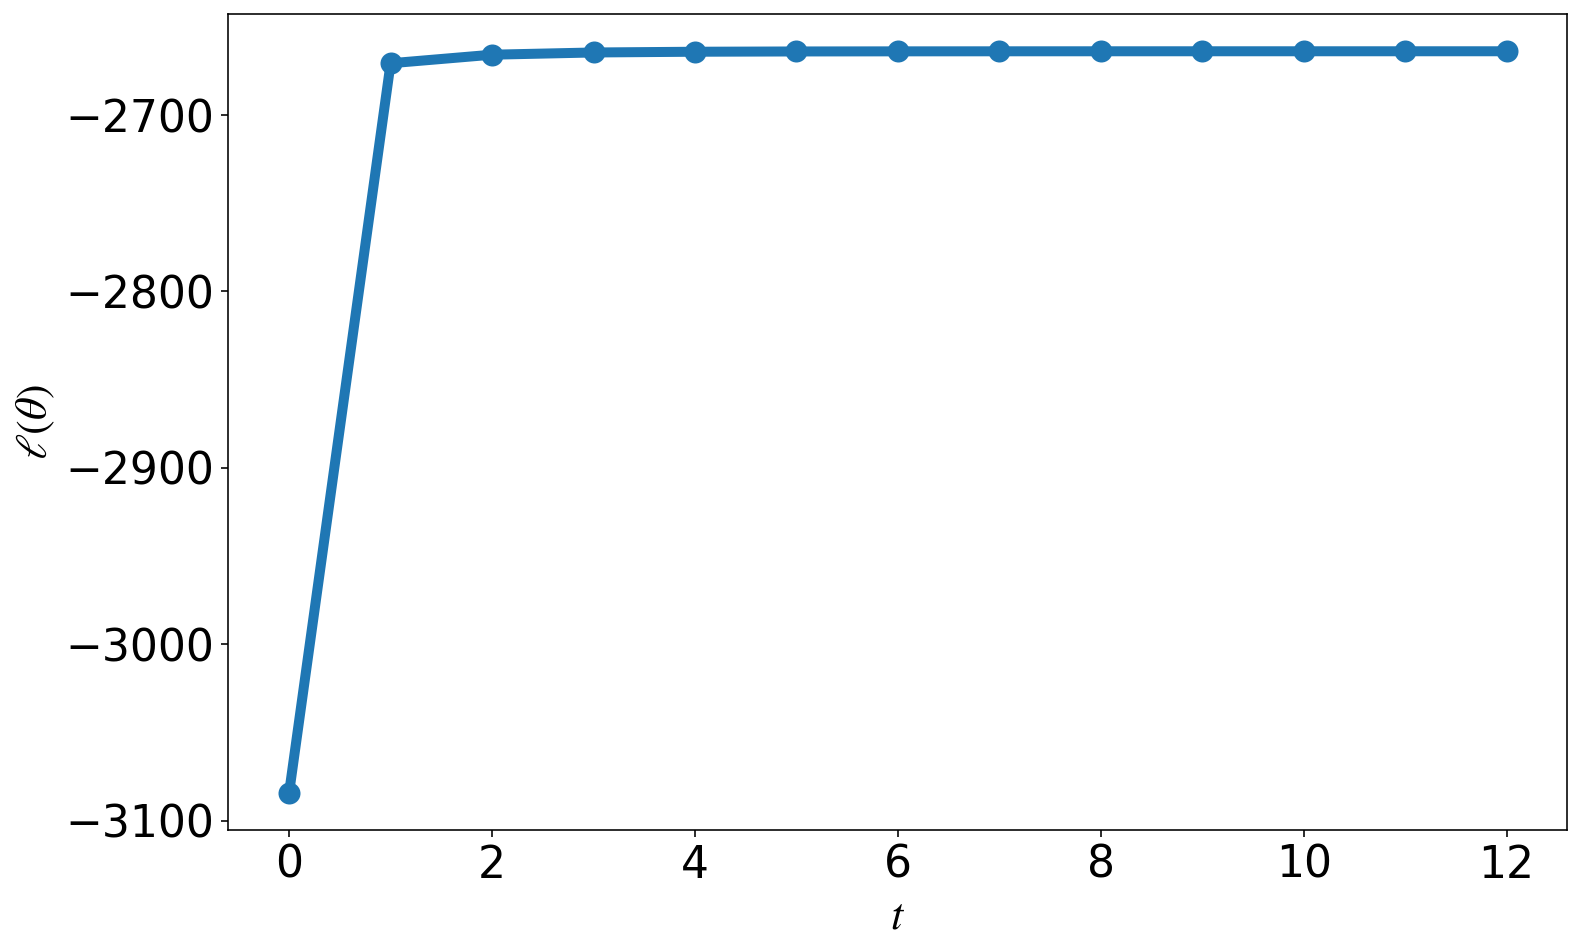

In [12]:
def mvnorm_1(x, theta):
    return spstats.multivariate_normal(theta[1], theta[2]).pdf(x)


def mvnorm_2(x, theta):
    return spstats.multivariate_normal(theta[-2], theta[-1]).pdf(x)


def fitted_pdf(x, theta):
    pi = theta[0]
    pdf = (1 - pi) * mvnorm_1(x, theta) + pi * mvnorm_2(x, theta)
    return pdf


def log_likelihood(x, theta):
    pi = theta[0]
    log_like = np.log(fitted_pdf(x, theta)).sum()
    return log_like


ll = []
tt = []
for idx, t, *theta in mvnorm_df.itertuples():
    tt.append(t)
    ll.append(log_likelihood(data, theta))

plt.figure()
plt.plot(tt, ll, '.-', lw=5, ms=20)
plt.xlabel('$t$')
plt.ylabel(r'$\ell (\theta)$')
plt.show()


 Our initial value makes it hard to visualize the convergence properties of
 the expectation-maximization algorithm. Let's try leaving off the initial
 guess.

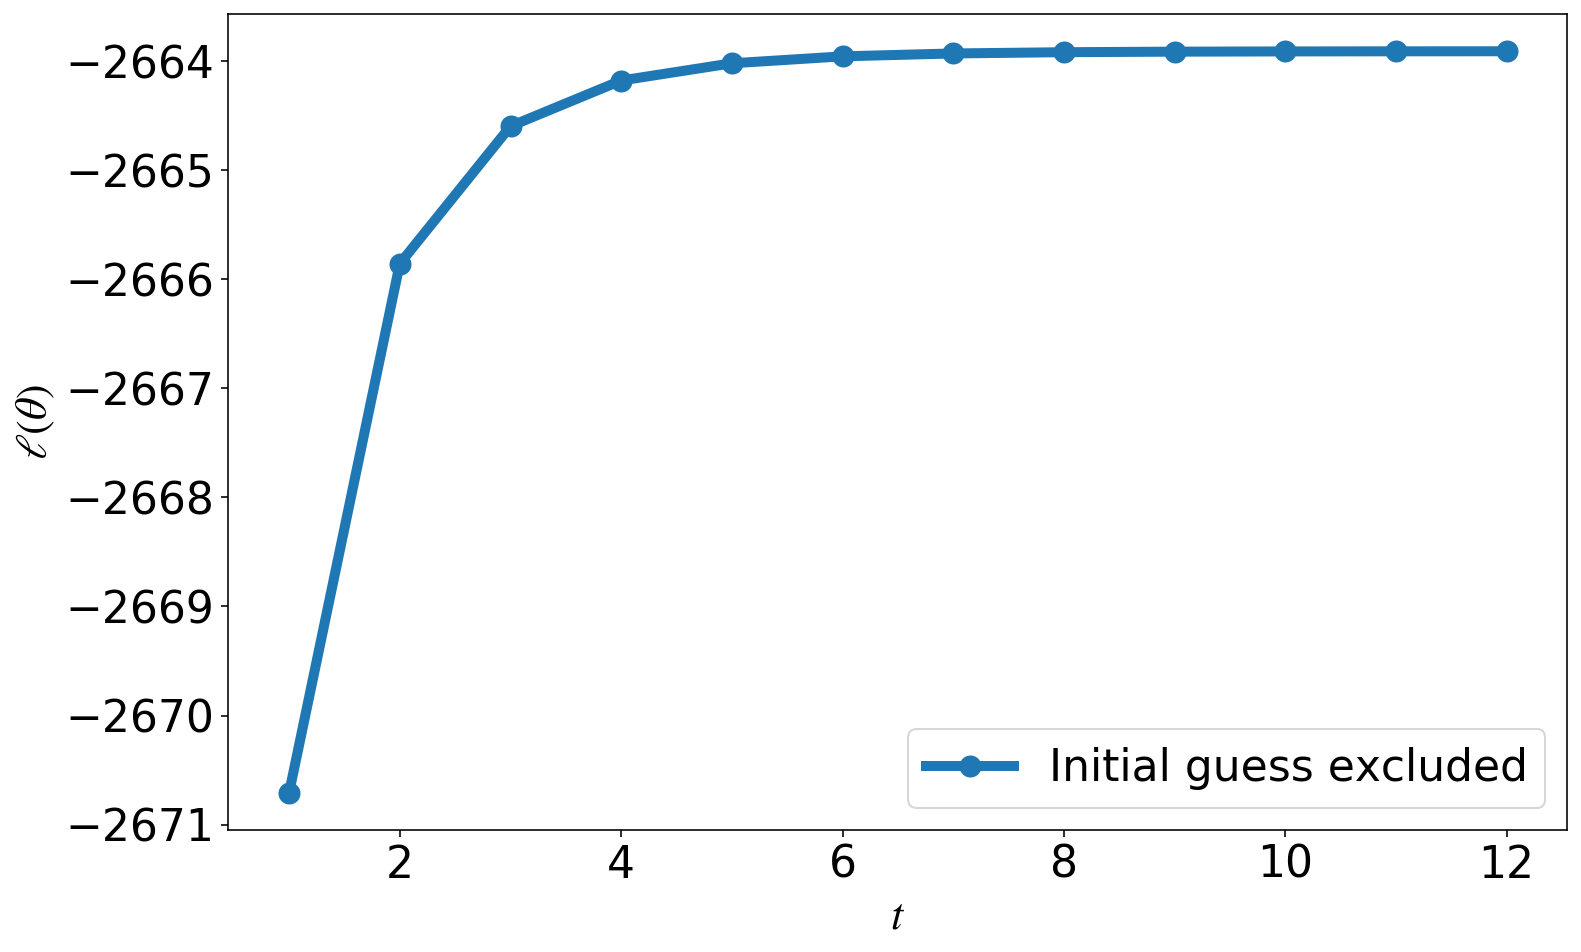

In [13]:
plt.figure()
plt.plot(tt[1:], ll[1:], '.-', label='Initial guess excluded', lw=5, ms=20)
plt.xlabel('$t$')
plt.ylabel(r'$\ell (\theta)$')
plt.legend()
plt.show()


 Much better, now it is clear that the algorithm results in a log-likelihood
 evaluation that is monotonically increasing.

 <br>
 <br>
 
 ### (c) Classify each observation into one of the two classes
 
 Display the classification results in a scatter plot with two different colors.

 We now have two bells sitting on top of our domain which represent the
 probability that a coordinate pair belongs to either. Therefore, we can
 evaluate each coordinate using each density function, and the one with higher
 probability will be the assigned class label.

In [14]:
prob_class_1 = mvnorm_1(data, theta_hat)
prob_class_2 = mvnorm_2(data, theta_hat)
in_class_1 = prob_class_1 > prob_class_2
in_class_2 = ~in_class_1

x1 = np.linspace(data.min()['x1'], data.max()['x1'])
x2 = np.linspace(data.min()['x2'], data.max()['x2'])

X1, X2 = np.meshgrid(x1, x2)
ll = np.full_like(X1, np.nan, dtype=float)
for idx in range(X1.size):
    ll.flat[idx] = fitted_pdf((X1.flat[idx], X2.flat[idx]), theta_hat)
    

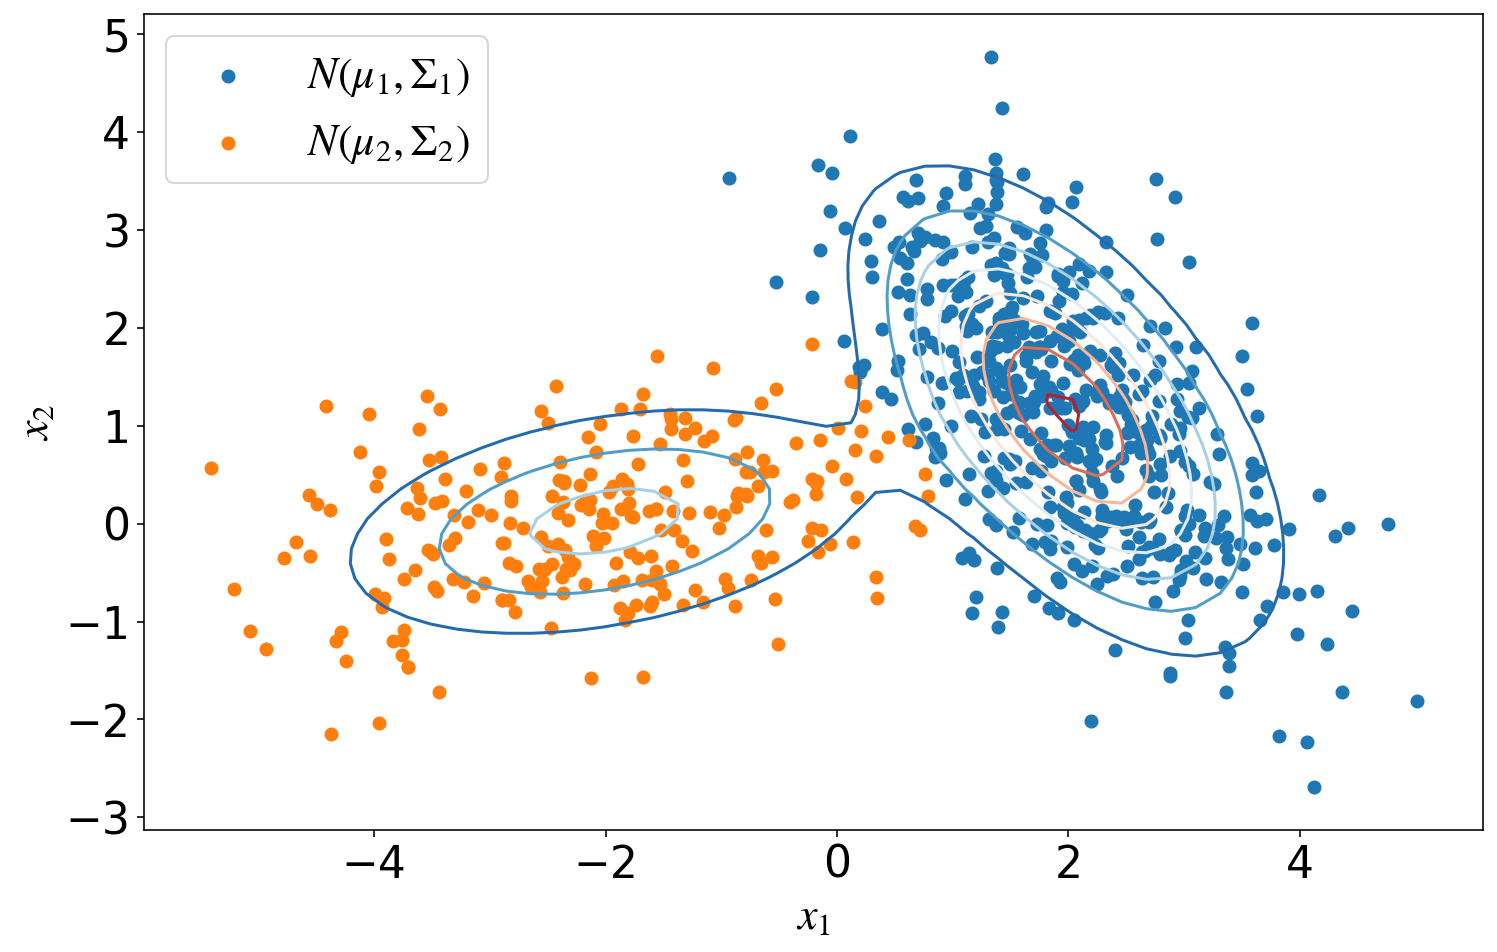

In [15]:
fig = plt.figure()
lvls = 8
cmp = 'RdBu_r'
plt.contour(X1, X2, ll, cmap=cmp, levels=lvls)
plt.scatter(data.loc[in_class_1, 'x1'], data.loc[in_class_1, 'x2'],
            label=r'$N(\mu_1, \Sigma_1)$')
plt.scatter(data.loc[in_class_2, 'x1'], data.loc[in_class_2, 'x2'],
            label=r'$N(\mu_2, \Sigma_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()


 A contour plot of the mixed distribution was added to show how well the
 classifier performed. For the most part, the data coordinates look well
 classified.

<br>
<br>

### (d) Create a surface plot of the fitted PDF $f(x; \mathbf{\hat{\theta}}).$

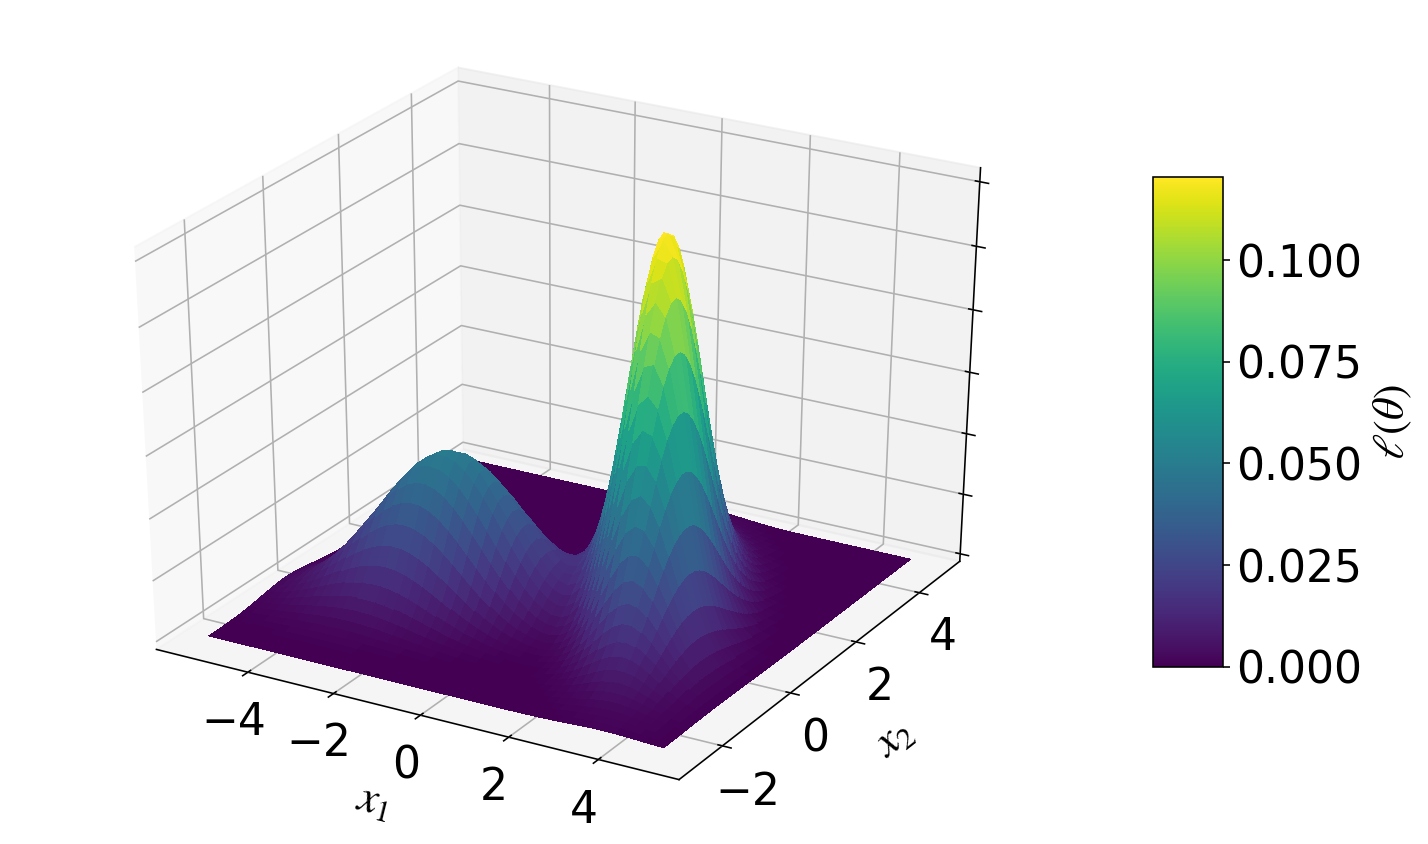

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X1, X2, ll, cmap='viridis', lw=0, antialiased=False)
ax.set_xlabel('\n' + r'$x_1$')
ax.set_ylabel('\n' + r'$x_2$')
ax.set_zticklabels([])
cbar = fig.colorbar(surf, shrink=0.6, aspect=7)
cbar.ax.set_ylabel(r'$\ell(\theta)$')
plt.show()


 <br>
 <br>
 
 ## Problem 3
 
 ---

 Let $\{a_1, \dots, a_n\}$ be a set of positive real number. Its _arithmetic
 mean_ (AM), _geometric mean_ (GM), _harmonic mean_ (HM) are defined as:

 $$AM = \frac{1}{n} \sum_{i=1}^n a_i,$$

 $$GM = \left( \prod_{i=1}^n a_i \right)^{1/n},$$

 $$HM = \frac{1}{\frac{1}{n} \sum_{i=1}^{n} \frac{1}{a_i}}.$$

 Prove:

 $$HM \leq GM \leq AM.$$

### Proof that $AM \geq GM$

Jensen's inequality states that

$$
\phi \left[ E(X) \right] \geq E \left[ \phi(X) \right]
$$

for ___concave___ function $\phi(X)$.

For our set of positive real numbers ${a_i}$,

$$
E(A) = \sum_{i=1}^n a_i\ p(a_i)
$$

but each element in a set is unique, so $p(z_i) = \frac{1}{n}$ for every $i$.

$$
\therefore E(A) = \frac{1}{n} \sum_{i=1}^n a_i
$$

We can use the fact that $log(X)$ is concave to show that

$$
\log \left( \frac{1}{n} \sum_{i=1}^n a_i \right) \geq \frac{1}{n} \sum_{i=1}^n \left( \log a_i \right)
$$

$$
\geq \sum_{i=1}^n \frac{1}{n} \log a_i
$$

$$
\geq \sum_{i=1}^n \log a_i^{1/n}
$$

$$
\geq \log \left( \prod_{i=1} a_i^{1/n} \right)
$$

$$
\geq \log \left( \prod_{i=1} a_i \right)^{1/n}
$$

So, we have that

$$
\log AM \geq \log GM
$$

and exponentiating both sides results in

$$
\therefore AM \geq GM
$$

### Proof that $GM \geq HM$

Now, the reciprocal of the harmonic mean results in the arithmetic mean of the reciprocal of the set

$$
(HM)^{-1} = AM\left(\frac{1}{a_i} \right).
$$

Which we now know must be greater than or equal to the geometric mean

$$
(HM)^{-1} \geq GM\left( \frac{1}{a_i} \right).
$$

So,

$$
(HM)^{-1} \geq \left(\prod_{i=1}^n \frac{1}{a_i} \right)^{1/n}
$$

$$
\geq \left(  \prod_{i=1}^n \left( \frac{1}{a_i} \right)^{-1}  \right)^{-1/n}
$$

$$
\geq \left( \prod_{i=1}^n a_i  \right)^{-1/n},
$$

which is the reciprocal of the geometric mean

$$
(HM)^{-1} \geq (GM)^{-1}.
$$

Now, noting that every element of the set is a positive real number, taking the reciprocal reverses the inequality

$$
\therefore HM \leq GM.
$$

### Result

$$
HM \leq GM \leq AM.
$$